In [48]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import os
import scipy.io
import numpy as np
import statistics, math
import matplotlib.pyplot as plt
from libs import util_matlab as umatlab
from libs import datasets, dataset_utils, utils
from sklearn import preprocessing
# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

Read Data

In [53]:
data_dir="/Users/alfonso/matlab/IndirectAcquisition/keras/dataforMarius/export"
files = [os.path.join(data_dir, file_i) for file_i in os.listdir(data_dir) if file_i.endswith('.mat')]

matlabStruct=umatlab.loadmat(files[1]).get('data')
energyBand=matlabStruct.get('energyBand')
energyBandStd = preprocessing.scale(energyBand)
energyBand_min_max_scaler = preprocessing.minmax_scale(energyBand)
energyBand=(energyBand /120 )+1 #normalize [0-1]
totalSecs=matlabStruct.get('waveIn').shape[0]/matlabStruct.get('audioSR')
energyBands_sr=energyBand.shape[1]/totalSecs #This is around 100Hz-10ms
controlNames=matlabStruct.get('controlNames')
controlData=matlabStruct.get('controlData')

indexVel=[i for i in range(controlNames.shape[0]) if controlNames[i] == 'abs(velocity)'][0]
indexForce=[i for i in range(controlNames.shape[0]) if controlNames[i] == 'forceN'][0]
velocity=controlData[indexVel,:]/150
force=(controlData[indexForce,:]+0.2)/2

#string=controlData[0,:]
#pitch=controlData[6,:]/1500

# We want 500? milliseconds of audio in our window
windowSize=int((0.25*energyBands_sr)//2*2)
# And we'll move our window by 250 ms at a time
hopSize=windowSize//2
n_hops = (energyBand.shape[1]) // hopSize
print('windowSize', windowSize)

windowSize 60


Build dataset

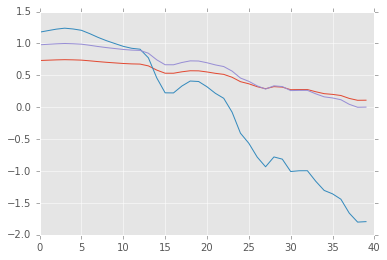

In [54]:
plt.plot(energyBand[:,100])
plt.plot(energyBandStd[:,100])
plt.plot(energyBand_min_max_scaler[:,100])

In [3]:
controlNames

array(['string', 'abs(velocity)', 'forceN', 'acc(abs(vel)', 'tilt', 'bbd',
       'pitch', 'rms'], dtype=object)

In [4]:
Xs = []
ys = []
n_input=energyBand.shape[0]
# Let's start with the music files
for filename in files:
    #print(filename)
    matlabStruct=umatlab.loadmat(filename).get('data')
    energyBand=(matlabStruct.get('energyBand')/120)+1
    controlData=matlabStruct.get('controlData')
    controlNames=matlabStruct.get('controlNames')
    target=controlData[indexVel,:]/150
    #target=(controlData[indexForce,:]+0.2)/2
    
    n_hops = (energyBand.shape[1]) // hopSize
    
    #print(n_frames_per_second, n_frames, frame_hops, n_hops)
    n_hops=int(n_hops)-1
    for hop_i in range(n_hops):
        # Creating our sliding window
        frames = energyBand[:,(hop_i * hopSize):(hop_i * hopSize + windowSize)]
        Xs.append(frames.T) #[..., np.newaxis])
        # And then store the vel 
        ys.append(target[(hop_i * hopSize):(hop_i * hopSize + windowSize)])

Xs = np.array(Xs)
ys = np.array(ys)
print(Xs.shape, ys.shape)

(18787, 60, 40) (18787, 60)


In [5]:
n_observations, sequence_L, n_inputs = Xs.shape

In [6]:
ds = datasets.Dataset(Xs=Xs, ys=ys, split=[0.8, 0.1, 0.1], n_classes=0)

In [55]:
Xs_i, ys_i = next(ds.train.next_batch())

# Notice the shape this returns.  This will become the shape of our input and output of the network:
print(Xs_i.shape, ys_i.shape)

(100, 60, 40) (100, 60)


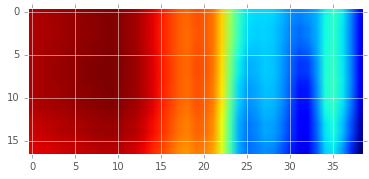

In [8]:
plt.imshow(Xs_i[1,1:18,1:40])

In [69]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10


# Network Parameters
n_inputs = energyBand.shape[0] # spectral data input (bands: 40)
sequence_length = windowSize
n_cells = 128 # hidden layer num of features
#n_classes = 10 # MNIST total classes (0-9 digits)
n_layers=1

# tf Graph input
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, sequence_length, n_inputs], name='X')
# We'll have a placeholder for our true outputs
Y = tf.placeholder(tf.float32, [None, sequence_length], name='Y')

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_cells, sequence_length]))
}
biases = {
    'out': tf.Variable(tf.random_normal([sequence_length]))
}
#or...
#with tf.variable_scope('prediction'):
#    W = tf.get_variable(
#        "W",
#        shape=[n_cells, n_chars],
#        initializer=tf.random_normal_initializer(stddev=0.1))
#    b = tf.get_variable(
#        "b",
#        shape=[n_chars],
#        initializer=tf.random_normal_initializer(stddev=0.1))

In [70]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, sequence_length, n_inputs)
    # Required shape: 'sequence_length' tensors list of shape (batch_size, n_inputs)
    
    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2]) #sequence_length, batch_size. n_inputs
    # Reshaping to (sequence_length*batch_size, n_inputs)
    x = tf.reshape(x, [-1, n_inputs])
    # Split to get a list of 'sequence_length' tensors of shape (batch_size, n_inputs)
    x = tf.split(0, sequence_length, x)
    
    
    if n_layers > 1:
        #lstm_cells = tf.nn.rnn_cell.MultiRNNCell([n_cells] * n_layers, state_is_tuple=True)
        #initial_state = lstm_cells.zero_state(tf.shape(X)[0], tf.float32)
        basic_cells = lstm_cells = rnn_cell.BasicLSTMCell(n_cells, state_is_tuple=True, forget_bias=1.0)
        #initial_state = lstm_cells.zero_state(tf.shape(X)[0], tf.float32)
        lstm_cells = rnn_cell.MultiRNNCell([basic_cells] * n_layers, state_is_tuple=True)
    else:
        # Define a lstm cell with tensorflow
        #lstm_cells = rnn_cell.BasicLSTMCell(n_cells, state_is_tuple=True, forget_bias=1.0)
        #initial_state = lstm_cells.zero_state(tf.shape(x)[0], tf.float32)
        #code from MLTutorials
        init = tf.random_normal_initializer(stddev=0.05)
        lstm_cells = tf.nn.rnn_cell.LSTMCell(n_cells, initializer=init, state_is_tuple=True)
    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cells, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(X, weights, biases)

# Define loss and optimizer
loss = tf.squared_difference(pred,Y) #pred & Y & loss are [Batch_size, sequence_length]
mySum= tf.reduce_sum(loss, 1) # sum is [sequence_length]
cost = tf.reduce_mean(mySum)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Evaluate model
#correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
#accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

TypeError: inputs must be a list

In [57]:
batch_x, batch_y = next(ds.train.next_batch())


In [64]:
#check RNN inputs
print(batch_x.shape)
x = tf.transpose(batch_x, [1, 0, 2])
print(x.get_shape)
x = tf.reshape(x, [-1, n_inputs])
print(x.get_shape)
x = tf.split(0, sequence_length, x)
print(np.array(x).shape)

(100, 60, 40)
<bound method Tensor.get_shape of <tf.Tensor 'transpose_5:0' shape=(60, 100, 40) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'Reshape_3:0' shape=(6000, 40) dtype=float32>>
(60,)


In [68]:
x[59].get_shape

<bound method Tensor.get_shape of <tf.Tensor 'split_2:59' shape=(100, 40) dtype=float32>>

In [13]:
# Launch the graph
#with tf.Session() as sess:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [42]:
step = 1
# Train
this_cost = 0
its = 0
# Keep training until reach max iterations
while step * batch_size < training_iters:
    batch_x, batch_y = next(ds.train.next_batch())
    # Reshape data to get 28 seq of 28 elements
    #batch_x = batch_x.reshape((batch_size, sequence_length, n_inputs))
    # Run optimization op (backprop)
    this_cost +=sess.run([cost, optimizer], feed_dict={X: batch_x, Y: batch_y})[0]
    its += 1
    #if step % display_step == 0:
    print('Step:', step, ':Training cost: ', this_cost / its)
    #    # Calculate batch accuracy
    #    acc = sess.run(accuracy, feed_dict={X: batch_x, Y: batch_y})
    #    # Calculate batch loss
    #    loss = sess.run(cost, feed_dict={X: batch_x, Y: batch_y})
    #    print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
    #          "{:.6f}".format(loss) + ", Training Accuracy= " + \
    #          "{:.5f}".format(acc))
    step += 1

print("Optimization Finished!")

# Calculate accuracy for 128 mnist test images
#test_len = 128
#test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
#test_label = mnist.test.labels[:test_len]
#print("Testing Accuracy:", \
#    sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))

Step: 1 :Training cost:  0.612451016903
Step: 2 :Training cost:  0.636722654104
Step: 3 :Training cost:  0.635570764542
Step: 4 :Training cost:  0.643176347017
Step: 5 :Training cost:  0.633791828156
Step: 6 :Training cost:  0.646879514058
Step: 7 :Training cost:  0.64878812858
Step: 8 :Training cost:  0.655042953789
Step: 9 :Training cost:  0.657987236977
Step: 10 :Training cost:  0.661495411396
Step: 11 :Training cost:  0.662796009671
Step: 12 :Training cost:  0.668627729019
Step: 13 :Training cost:  0.671974159204
Step: 14 :Training cost:  0.662379277604
Step: 15 :Training cost:  0.671244804064
Step: 16 :Training cost:  0.666977692395
Step: 17 :Training cost:  0.672315688694
Step: 18 :Training cost:  0.670301523474
Step: 19 :Training cost:  0.664396169939
Step: 20 :Training cost:  0.658788752556
Step: 21 :Training cost:  0.660879992303
Step: 22 :Training cost:  0.661997377872
Step: 23 :Training cost:  0.654987187489
Step: 24 :Training cost:  0.650218586127
Step: 25 :Training cost:  

KeyboardInterrupt: 

In [43]:
nBatches=22
Xs_i=np.zeros(shape=(nBatches,windowSize,40))
ys_i=np.zeros(shape=(nBatches,windowSize))
for i in range(nBatches):
    Xs_i[i,:,:]=energyBand[:,i*windowSize:i*windowSize+windowSize].T
    ys_i[i,:]=target[i*windowSize:i*windowSize+windowSize]

In [44]:
prediction=sess.run([pred], feed_dict={X:Xs_i, Y:ys_i})[0]
linPrediction = np.reshape(prediction, (np.product(prediction.shape)))
linOriginal = np.reshape(ys_i, (np.product(ys_i.shape)))

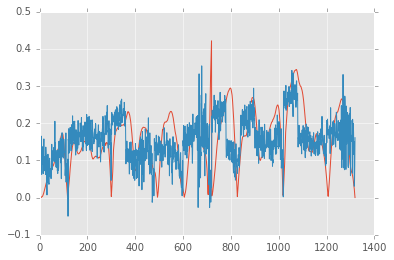

In [45]:
plt.plot(linOriginal)
plt.plot(linPrediction)

In [29]:
Xs_i, ys_i = next(ds.train.next_batch())
prediction=sess.run([pred], feed_dict={X:Xs_i, Y:ys_i})[0]
the_loss=sess.run([loss], feed_dict={X:Xs_i, Y:ys_i})[0]
the_sum=sess.run([mySum], feed_dict={X:Xs_i, Y:ys_i})[0]
the_cost=sess.run([cost], feed_dict={X:Xs_i, Y:ys_i})[0]

(0, 1)

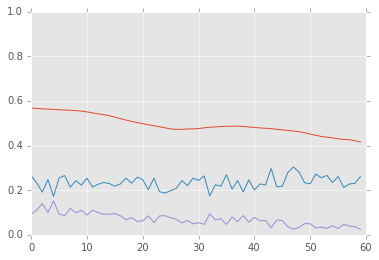

In [30]:
i=10
plt.plot(ys_i[i,:])
plt.plot(prediction[i,:])
plt.plot(the_loss[i,:])
#plt.plot(the_cost)
plt.ylim((0, 1))

In [ ]:
loss

In [ ]:
plt.plot(the_sum/18)

In [ ]:
np.mean(the_sum)

In [ ]:
the_cost

In [ ]:
0.7/18